## Read the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image, ImageDraw
import os
import shutil

# Model
import ultralytics
from ultralytics import YOLO
ultralytics.checks()


Ultralytics YOLOv8.2.8  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 226.6/237.9 GB disk)


### 2021 Data

In [2]:
# Useful Paths
root = r'data(2021)\\gwhd_2021\\'
current_path = os.getcwd()
image_path_relative = "\\data(2021)\\gwhd_2021\\images"

# Loading training dataset
data = pd.read_csv(root + 'competition_train.csv')
# Creating column 'path' to store file path
data['path'] = data.apply(lambda row : root + r'images\\' + row.image_name, axis = 1)

# Loading validation dataset
data_val = pd.read_csv(root + 'competition_val.csv')
# Creating column 'path' to store file path
data_val['path'] = data_val.apply(lambda row : root + r'images\\' + row.image_name, axis = 1)

# Loading test dataset
data_test = pd.read_csv(root + 'competition_test.csv')
# Creating column 'path' to store file path
data_test['path'] = data_test.apply(lambda row : root + r'images\\' + row.image_name, axis = 1)

In [3]:
data.BoxesString

0       99 692 160 764;641 27 697 115;935 978 1012 102...
1       230 143 321 222;928 929 1015 1004;485 557 604 ...
2       440 239 544 288;333 538 429 594;913 171 963 20...
3       112 274 188 303;892 812 958 847;0 889 67 928;1...
4       810 204 863 314;360 231 425 408;452 348 510 47...
                              ...                        
3652    53 81 175 142;0 0 100 129;0 0 42 77;144 0 250 ...
3653    5 0 62 85;46 0 92 24;82 9 159 146;48 74 301 20...
3654    200 105 345 358;144 128 280 316;276 0 360 108;...
3655    0 0 214 84;0 114 57 170;0 322 24 367;56 382 16...
3656    98 0 158 41;0 0 42 49;0 78 26 143;324 86 374 1...
Name: BoxesString, Length: 3657, dtype: object

In [4]:
data_val.BoxesString

0       0 30 109 119;453 617 561 661;450 441 652 493;5...
1       38 370 88 443;924 824 964 874;0 191 39 265;828...
2       884 932 1024 990;828 53 1024 206;607 633 681 7...
3       284 114 352 181;421 0 533 90;910 326 954 409;8...
4       94 0 241 183;173 217 318 338;401 371 606 472;3...
                              ...                        
1471    570 966 606 1022;0 105 18 170;994 438 1024 474...
1472    0 193 229 274;808 449 951 540;361 359 429 430;...
1473                                      519 681 735 857
1474    613 290 647 322;6 754 74 813;593 155 652 219;3...
1475    340 302 408 347;316 270 386 307;562 965 695 10...
Name: BoxesString, Length: 1476, dtype: object

In [5]:
data_test.BoxesString

0       481 820 604 922;655 957 732 1024;930 926 1013 ...
1       896 911 977 955;800 898 821 941;770 867 804 90...
2       892 993 922 1024;844 943 871 965;758 926 801 9...
3       648 886 722 1024;392 950 507 1024;876 677 981 ...
4       559 939 623 1009;775 875 829 919;853 883 888 9...
                              ...                        
1377    88 315 166 477;242 506 288 641;131 622 180 752...
1378    179 420 230 497;65 379 134 422;114 281 173 358...
1379    81 161 182 302;235 199 365 289;0 290 111 413;4...
1380    539 636 774 711;439 732 599 865;635 847 892 94...
1381    78 816 183 922;180 815 245 920;417 802 525 100...
Name: BoxesString, Length: 1382, dtype: object

#### the necessary processing for yolo5+ (it may be possible to use for other big libraries as well)

In [6]:
#probably the unholiest code chain I have written

# need to derive the indivivual boxes for Models
def string_to_array(group_string):
    group_strings = group_string.split(';')
    groups = []
    for group_str in group_strings:
        group = []
        for item in group_str.split():
            try:
                group.append(int(item))
            except ValueError:
                pass  # Skip non-integer values
        groups.append(group)
    return groups


# Apply the function to each element of the column and create a new column with the arrays
data['BoxesString'] = data['BoxesString'].apply(string_to_array)
data_val['BoxesString'] = data_val['BoxesString'].apply(string_to_array)
data_test['BoxesString'] = data_test['BoxesString'].apply(string_to_array)

# Print the DataFrame with the new column
data.head()

image_name  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...   
1  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...   
2  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...   
3  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...   
4  be1652110a44acd24b42784356e965ce84a04893c3f1bb...   

                                         BoxesString     domain  \
0  [[99, 692, 160, 764], [641, 27, 697, 115], [93...  Arvalis_1   
1  [[230, 143, 321, 222], [928, 929, 1015, 1004],...  Arvalis_1   
2  [[440, 239, 544, 288], [333, 538, 429, 594], [...  Arvalis_1   
3  [[112, 274, 188, 303], [892, 812, 958, 847], [...  Arvalis_1   
4  [[810, 204, 863, 314], [360, 231, 425, 408], [...  Arvalis_1   

                                                path  
0  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  
1  data(2021)\\gwhd_2021\\images\\a2a15938845d981...  
2  data(2021)\\gwhd_2021\\images\\401f89a2bb6ab63...  
3  data(2021)\\gwhd_2021\\images\\0a3937653483c36...  
4  data(2021)\\gwhd_2021\\images\\be1652110a44acd...

In [7]:
data_val.head()

image_name  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   
1  53889799be1319296f102fa09a512463c27316a428bb9f...   
2  ec8f9365ca93eb9dab075c64e5c8b32edd4f8993e17b89...   
3  48bab0505514c876207b4ede1c60cc906947ca02bb4277...   
4  44bf4657132a886bea1b74e105c3aadfa41ba7a2ae9d7a...   

                                         BoxesString   domain  \
0  [[0, 30, 109, 119], [453, 617, 561, 661], [450...  Usask_1   
1  [[38, 370, 88, 443], [924, 824, 964, 874], [0,...  Usask_1   
2  [[884, 932, 1024, 990], [828, 53, 1024, 206], ...  Usask_1   
3  [[284, 114, 352, 181], [421, 0, 533, 90], [910...  Usask_1   
4  [[94, 0, 241, 183], [173, 217, 318, 338], [401...  Usask_1   

                                                path  
0  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  
1  data(2021)\\gwhd_2021\\images\\53889799be13192...  
2  data(2021)\\gwhd_2021\\images\\ec8f9365ca93eb9...  
3  data(2021)\\gwhd_2021\\images\\48bab0505514c87...  
4  data(2021)\\gwhd_2021\\images\\44bf4657132a886...

In [8]:
data_test.head()

image_name  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...   
1  7f5eb37cab658de6fd0d688bf27f16e423794fed6184d8...   
2  7bcfff43b356f4a94948367782aa704a37ff4579baf45d...   
3  e535384eda9d0f9c6ac57dd9397d5d614e4cad48c144d8...   
4  66e9fa7379fd7b7fd64024ac1b03b8e56f9ad020c10635...   

                                         BoxesString domain  \
0  [[481, 820, 604, 922], [655, 957, 732, 1024], ...   UQ_7   
1  [[896, 911, 977, 955], [800, 898, 821, 941], [...   UQ_7   
2  [[892, 993, 922, 1024], [844, 943, 871, 965], ...   UQ_7   
3  [[648, 886, 722, 1024], [392, 950, 507, 1024],...   UQ_7   
4  [[559, 939, 623, 1009], [775, 875, 829, 919], ...   UQ_7   

                                                path  
0  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...  
1  data(2021)\\gwhd_2021\\images\\7f5eb37cab658de...  
2  data(2021)\\gwhd_2021\\images\\7bcfff43b356f4a...  
3  data(2021)\\gwhd_2021\\images\\e535384eda9d0f9...  
4  data(2021)\\gwhd_2021\\images\\66e9fa7379fd7b7...

In [9]:
# Explode the flattened array into individual rows
df_expanded = data.explode('BoxesString').reset_index(drop=True)
df_expanded.head()

image_name             BoxesString  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [99, 692, 160, 764]   
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [641, 27, 697, 115]   
2  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...  [935, 978, 1012, 1020]   
3  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [377, 834, 463, 890]   
4  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [654, 797, 696, 837]   

      domain                                               path  
0  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  
1  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  
2  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  
3  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  
4  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...

In [10]:
df_expanded_val = data_val.explode('BoxesString').reset_index(drop=True)
df_expanded_val.head()

image_name           BoxesString  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...     [0, 30, 109, 119]   
1  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [453, 617, 561, 661]   
2  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [450, 441, 652, 493]   
3  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [594, 617, 633, 657]   
4  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   [11, 719, 100, 840]   

    domain                                               path  
0  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  
1  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  
2  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  
3  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  
4  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...

In [11]:
df_expanded_test = data_test.explode('BoxesString').reset_index(drop=True)
df_expanded_test.head()

image_name             BoxesString  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...    [481, 820, 604, 922]   
1  255b6ca9fea63f44125e5174bc932470b604c760430715...   [655, 957, 732, 1024]   
2  255b6ca9fea63f44125e5174bc932470b604c760430715...  [930, 926, 1013, 1024]   
3  255b6ca9fea63f44125e5174bc932470b604c760430715...    [809, 851, 910, 924]   
4  255b6ca9fea63f44125e5174bc932470b604c760430715...    [836, 904, 866, 967]   

  domain                                               path  
0   UQ_7  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...  
1   UQ_7  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...  
2   UQ_7  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...  
3   UQ_7  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...  
4   UQ_7  data(2021)\\gwhd_2021\\images\\255b6ca9fea63f4...

In [12]:
def extract_array_elements(row):
    return pd.Series(row['BoxesString'])

# Apply the function to create new columns
df_expanded[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded.apply(extract_array_elements, axis=1)
df_expanded_val[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded_val.apply(extract_array_elements, axis=1)
df_expanded_test[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded_test.apply(extract_array_elements, axis=1)

In [13]:
df_expanded.head()

image_name             BoxesString  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [99, 692, 160, 764]   
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [641, 27, 697, 115]   
2  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...  [935, 978, 1012, 1020]   
3  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [377, 834, 463, 890]   
4  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [654, 797, 696, 837]   

      domain                                               path  x_min  y_min  \
0  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...   99.0  692.0   
1  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  641.0   27.0   
2  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  935.0  978.0   
3  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  377.0  834.0   
4  Arvalis_1  data(2021)\\gwhd_2021\\images\\4563856cc6d75c6...  654.0  797.0   

    x_max   y_max  
0   160.0   764.0  
1   697.0   115.0  
2  1012.0  1020.0  
3   463.0   890.0  
4   696.0   837.0

In [14]:
df_expanded_val.head()

image_name           BoxesString  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...     [0, 30, 109, 119]   
1  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [453, 617, 561, 661]   
2  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [450, 441, 652, 493]   
3  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [594, 617, 633, 657]   
4  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   [11, 719, 100, 840]   

    domain                                               path  x_min  y_min  \
0  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...    0.0   30.0   
1  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  453.0  617.0   
2  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  450.0  441.0   
3  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...  594.0  617.0   
4  Usask_1  data(2021)\\gwhd_2021\\images\\e6b6a900e5c54cd...   11.0  719.0   

   x_max  y_max  
0  109.0  119.0  
1  561.0  661.0  
2  652.0  493.0  
3  633.0  657.0  
4  100.0  840.0

##### Data Visualization 

number of boxes, range [1, 129]


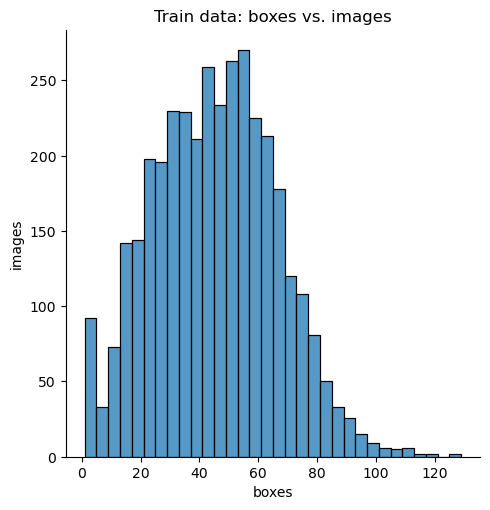

In [15]:
counts = df_expanded['image_name'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('Train data: boxes vs. images')
plt.show()

number of boxes, range [1, 129]


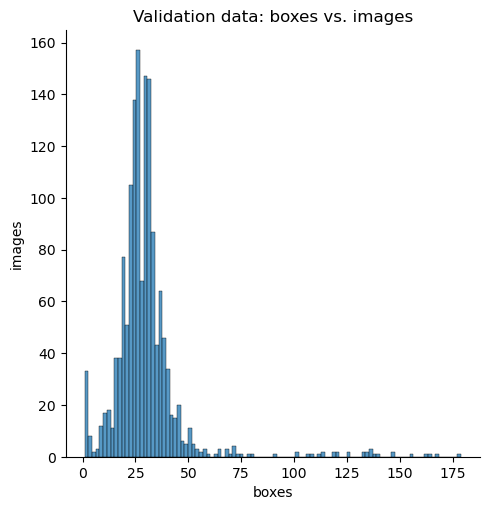

In [16]:
counts_val = df_expanded_val['image_name'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts_val, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('Validation data: boxes vs. images')
plt.show()

Number of Domains:  18


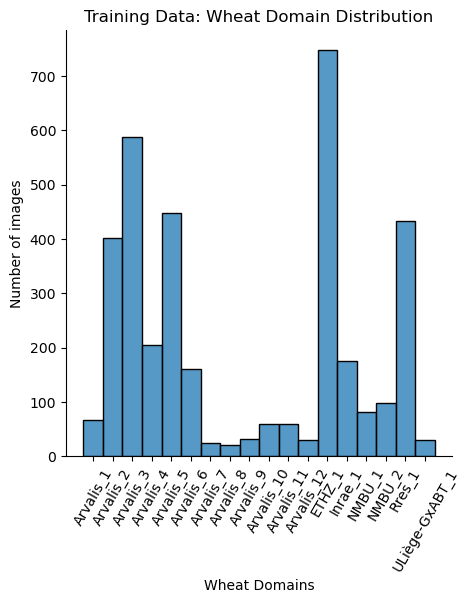

In [17]:
print("Number of Domains: ", len(data["domain"].unique()))
sns.displot(data["domain"], kde=False)
plt.xlabel('Wheat Domains')
plt.ylabel('Number of images')
plt.xticks(rotation=60)
plt.title('Training Data: Wheat Domain Distribution')
plt.show()

Number of Domains:  11


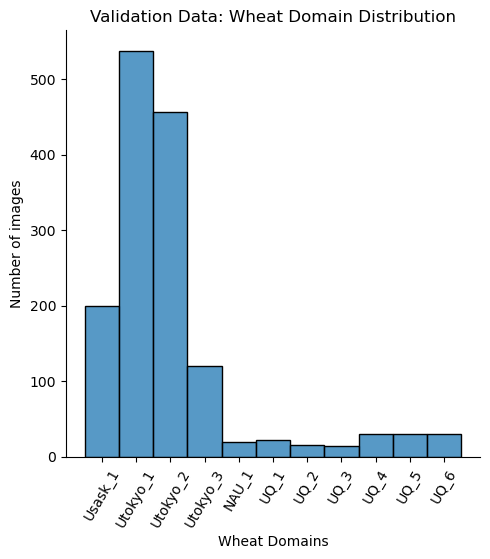

In [18]:
print("Number of Domains: ", len(data_val["domain"].unique()))
sns.displot(data_val["domain"], kde=False)
plt.xlabel('Wheat Domains')
plt.ylabel('Number of images')
plt.xticks(rotation=60)
plt.title('Validation Data: Wheat Domain Distribution')
plt.show()

## Visualizing Ground Truth Data

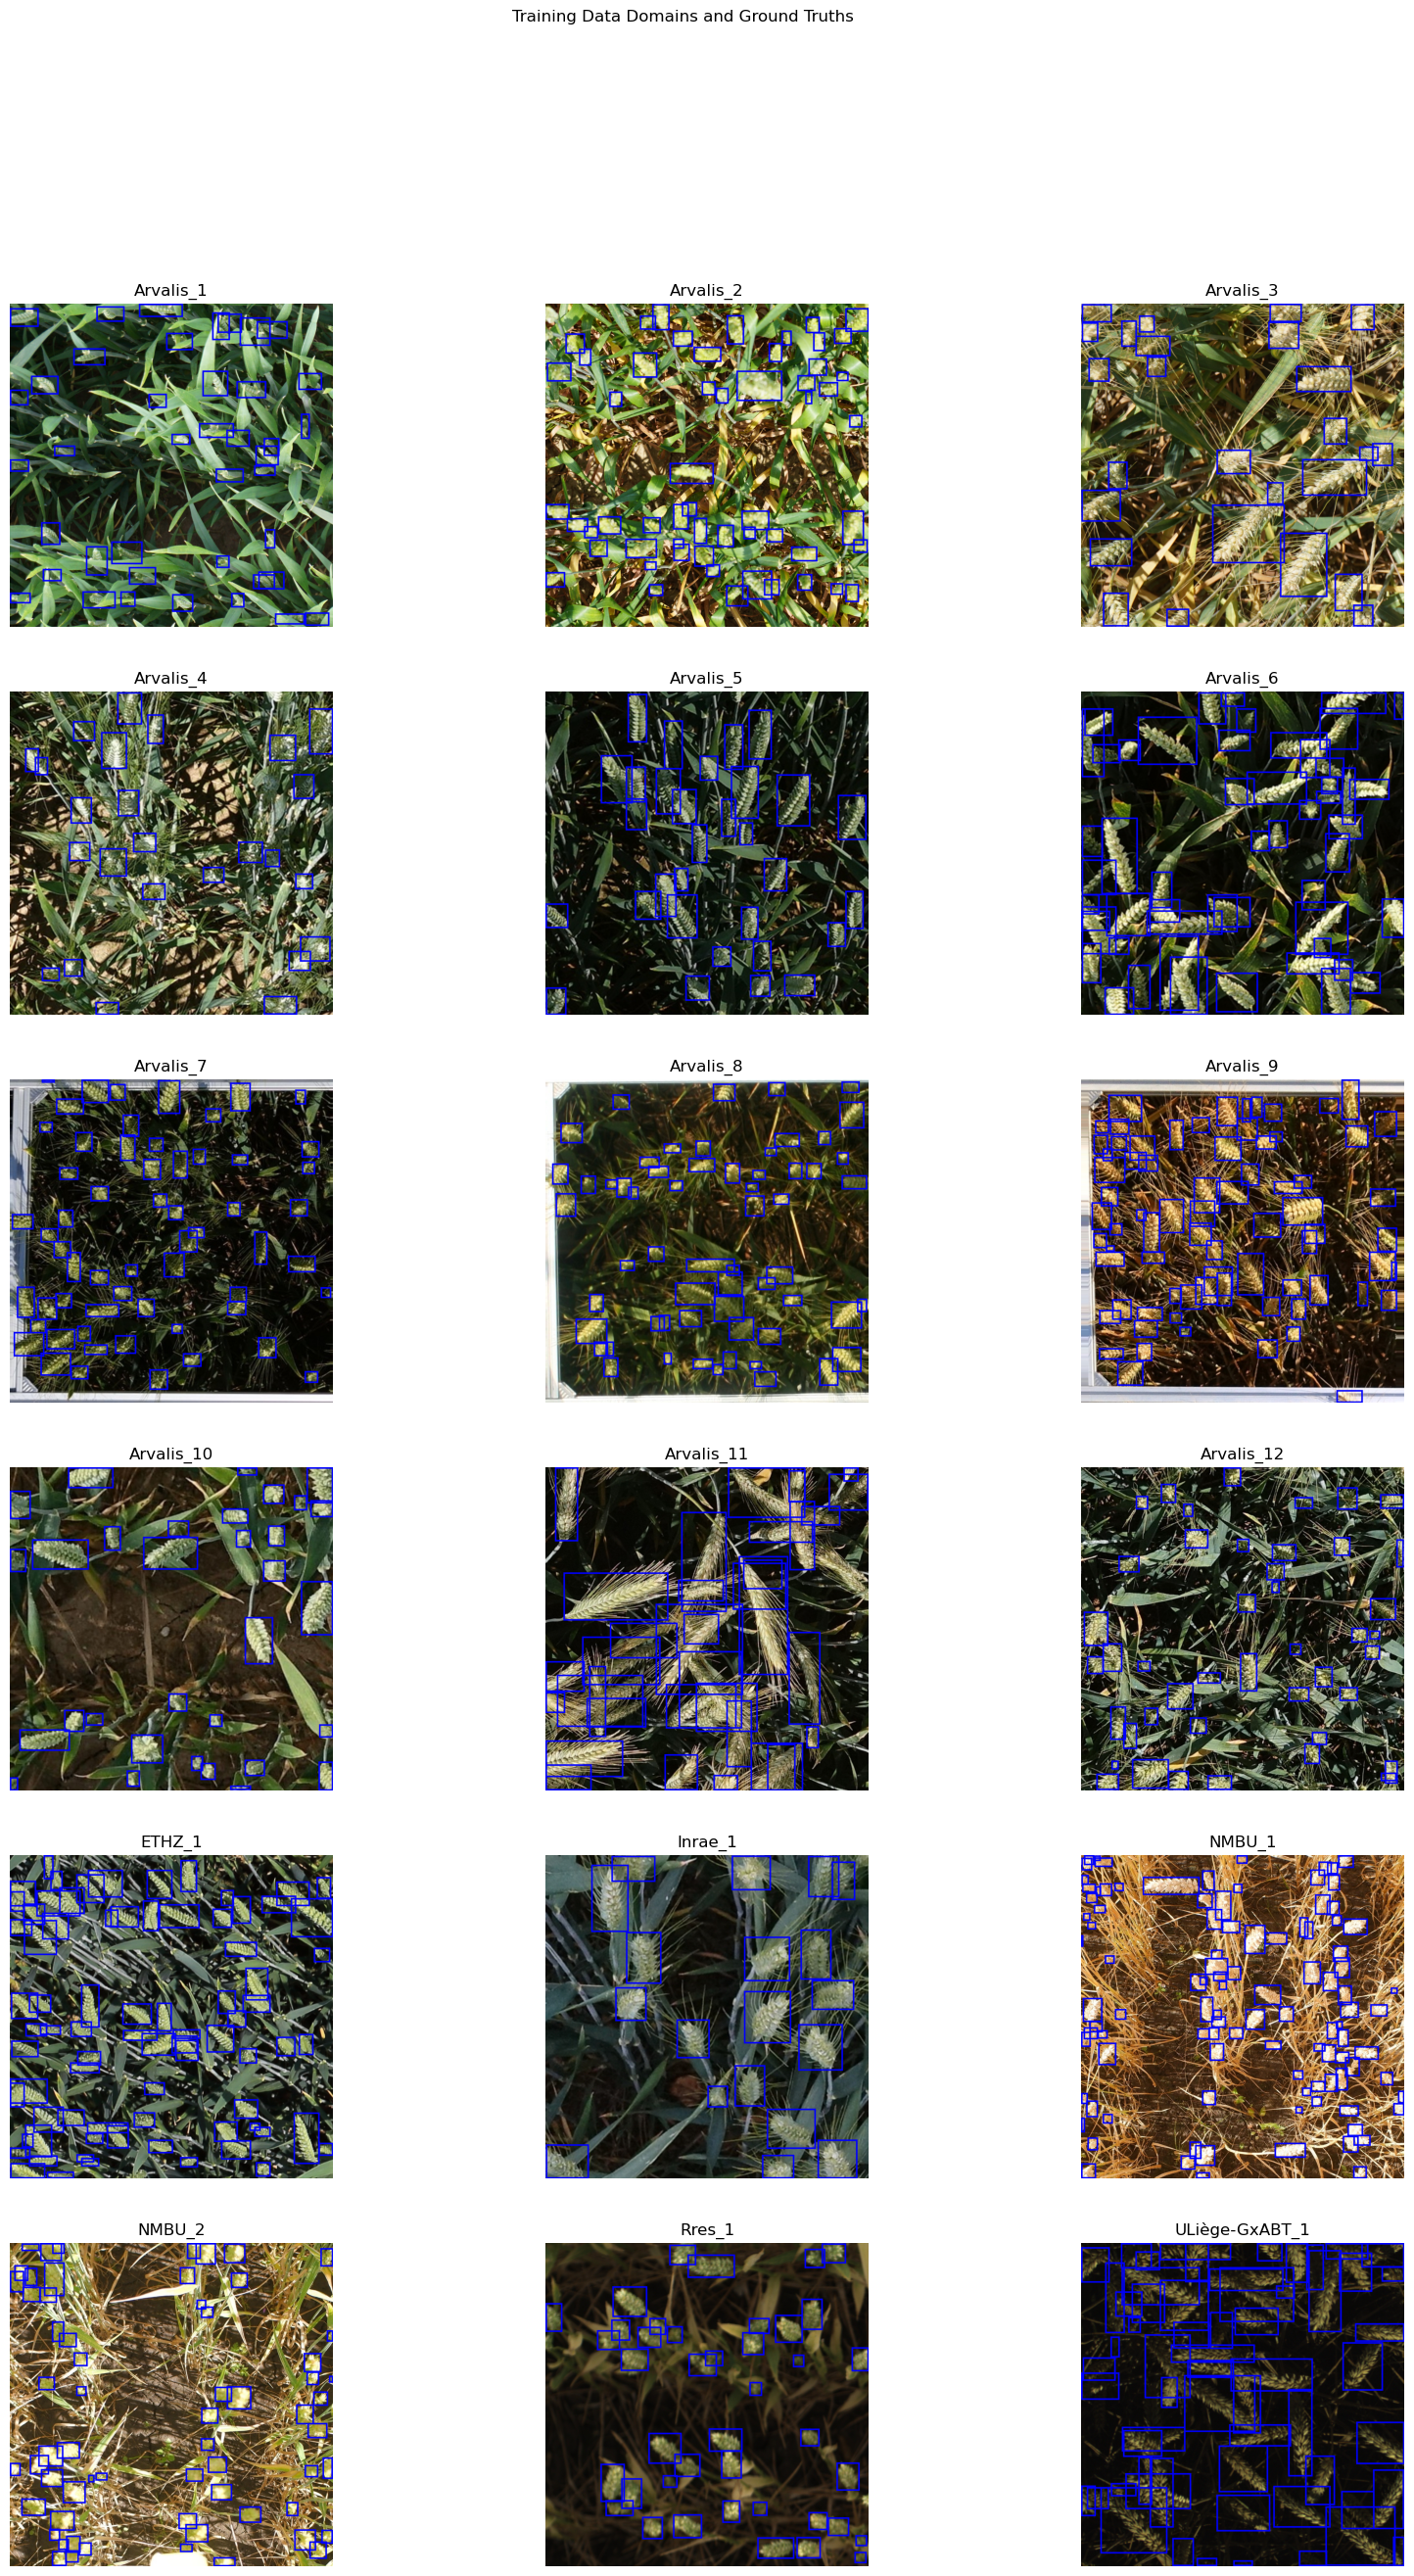

In [21]:
domain_list = iter(data["domain"].unique())
fig, axs = plt.subplots(6, 3, figsize=(20, 30))

for rows in range(axs.shape[0]):
    for cols in range(axs.shape[1]):
        for region in domain_list:
            sample = data[data["domain"] == region].iloc[0]
            with Image.open(current_path + image_path_relative + "\\" +sample["image_name"]) as im:
                draw = ImageDraw.Draw(im)
                for loc in sample["BoxesString"]:
                    xy = [(loc[0], loc[1]),(loc[2], loc[3])]
                    draw.rectangle(xy=xy, outline ="blue", width=5)
                axs[rows][cols].imshow(im)
                axs[rows][cols].axis("off")
                axs[rows][cols].title.set_text(region) 
            break
plt.suptitle('Training Data Domains and Ground Truths') # or plt.suptitle('Main title')
plt.show()

## Training Pipeline (YOLO V8)

#### **WARNING**: This pipeline will change the data-folder structure and copy the images to different folders for having YOLO-formatted structure!! Be careful about you have enough storage.

#### Create Directories for train and validation

In [22]:
os.makedirs('data(2021)/gwhd_2021/train/images', exist_ok = True)
os.makedirs('data(2021)/gwhd_2021/val/images', exist_ok = True)
os.makedirs('data(2021)/gwhd_2021/test/images', exist_ok = True)


os.makedirs('data(2021)/gwhd_2021/train/labels', exist_ok = True)
os.makedirs('data(2021)/gwhd_2021/val/labels', exist_ok = True)
os.makedirs('data(2021)/gwhd_2021/test/labels', exist_ok = True)


#### Copy Train and Validation Images to specific folders

In [23]:
def move_data_another_dir_YOLO(data_type):
    if data_type == "train":
        main_data = data
    elif data_type == "val":
        main_data = data_val
    elif data_type == "test":
        main_data = data_test
    else:
        print("DATA TYPE CANNOT BE FOUND")
        return
    
    destination_directory = f"data(2021)\\gwhd_2021\\{data_type}\\images" 
    for sample_idx in range(len(main_data)):
        data_sample_name = main_data.iloc[sample_idx]["path"]
        shutil.copy(data_sample_name, destination_directory)

In [24]:
move_data_another_dir_YOLO("train")

In [25]:
move_data_another_dir_YOLO("val")

In [26]:
move_data_another_dir_YOLO("test")

#### Creating YOLO-based bounding boxes

In [27]:
def format_labels_YOLO(data_type): #Converts  [x_min,y_min, x_max,y_max] -> [x_center, y_center, w, h] with normalized manner
    if data_type == "train":
        main_data = df_expanded
    elif data_type == "val":
        main_data = df_expanded_val
    elif data_type == "test":
        main_data = df_expanded_test
    else:
        print("DATA TYPE CANNOT BE FOUND")
        return

    for sample_idx in range(len(main_data)):
        image_name = main_data.path[sample_idx].split("\\\\")[-1].split('.')[0]
        destination_dir = f'data(2021)/gwhd_2021/{data_type}/labels/{image_name}.txt'
        sample_bbox = main_data.iloc[sample_idx].BoxesString        #Contains  [x_min,y_min, x_max,y_max] -> [x_center, y_center, w, h]

        if len(sample_bbox) == 0:   #If there is no label for given image
            box = None
        else:
            x_center = ((sample_bbox[0] + sample_bbox[2]) / 2) / 1024
            y_center = ((sample_bbox[1] + sample_bbox[3]) / 2) / 1024

            width = abs(sample_bbox[2] - sample_bbox[0]) / 1024
            height = abs(sample_bbox[3] - sample_bbox[1]) / 1024

            box = f'0 {x_center} {y_center} {width} {height}'+'\n'

            with open(destination_dir, 'a') as label_file:
                label_file.write(box)

In [28]:
format_labels_YOLO("train")

In [29]:
format_labels_YOLO("val")

In [30]:
format_labels_YOLO("test")

In [31]:
current_path

'c:\\Users\\evren\\Desktop\\application_project\\project_code'

#### Create YAML File for YOLOv8 (Change your path in accordance with your project path!!!)

In [3]:
import os

# Get the current working directory
current_dir = os.path.dirname(os.path.abspath('Pipeline.ipynb'))

# Construct paths relative to the current directory
project_path = os.path.join(current_dir, 'application_project', 'project_code')
train_path = os.path.join(current_dir, 'data(2021)', 'gwhd_2021', 'train', 'images')
val_path = os.path.join(current_dir, 'data(2021)', 'gwhd_2021', 'val', 'images')

# Create the content of the YAML file
content = f'''
path: '{project_path}'

train: '{train_path}'
val: '{val_path}'
    
names:
    0: wheat_head
'''

# Write the content to the YAML file
with open('GlobalWheatDataset.yaml', 'w') as file:
    file.write(content)


## Training

In [2]:
# Loading pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients


(225, 3157200, 0, 0.0)

In [3]:
# Training the model
results = model.train(
    data = 'GlobalWheatDataset.yaml',
    epochs = 50,
    batch = 32,
    imgsz = 1024,
    optimizer = 'Adam',
    workers=1
)

New https://pypi.org/project/ultralytics/8.2.16 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.8  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=GlobalWheatDataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

c:\Users\evren\anaconda3\envs\app_proj\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\labels.cache... 3605 images, 50 backgrounds, 0 corrupt: 100%|██████████| 3655/3655 [00:00<?, ?it/s]

train: WARNING  C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\images\502d5e4a8b89aeffaa6adf13e1215d27c2951230ab06a4fcb93732117196f124.png: 1 duplicate labels removed
train: WARNING  C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\images\8b461a21b9b01c657d41dfdf35b3607a0ab920c2cb78184c6e523391f5f3d554.png: 1 duplicate labels removed
train: WARNING  C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\images\9f697765bd41325baaf635d5389020270c4536200f97884928c014ac1d39ce12.png: 1 duplicate labels removed
train: WARNING  C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\images\c1db9589b954aa1ef2b5bf065d09aba926e674679a553c6dd6bfd5d6ae81f86a.png: 1 duplicate labels removed
train: WARNING  C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\train\images\ed17cba877ba4983b072ead24480913fb4cff9f1fc0f920e07021ca4f4f2ace2.png: 1 duplicate 


val: Scanning C:\Users\evren\Desktop\application_project\project_code\data(2021)\gwhd_2021\val\labels.cache... 1448 images, 28 backgrounds, 0 corrupt: 100%|██████████| 1476/1476 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 1 dataloader workers
Logging results to runs\detect\train12
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/115 [00:00<?, ?it/s]c:\Users\evren\anaconda3\envs\app_proj\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 0/115 [00:10<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 778.00 MiB. GPU 